# Análisis de las vecindades de los píxeles tras la transformación LBP

En primer lugar se realiza la carga de la imagen sobre la que se va a realizar el proceso y se indican los parámetros seleccionados.

In [4]:
from preprocess.preprocess import *
import PARAMETERS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from confusion_matrix_pretty_print import print_confusion_matrix
from main import init_clf_and_fit
import zipfile

%matplotlib inline

PARAMETERS.LBP_METHOD = 'default'
PARAMETERS.METHOD = 'get_pyramid_dataset'
PARAMETERS.INTERPOLATION_ALGORITHM = 'lanczos'
PARAMETERS.BALANCE = False
PARAMETERS.N_SCALES = 1
PARAMETERS.GRAY_INTENSITY = False
PARAMETERS.X2SCALE = False
PARAMETERS.FILE_EXTENSION = PARAMETERS.update_file_extension(PARAMETERS)

pd.DataFrame({k: getattr(PARAMETERS, k) for k in VALID_PARAMETERS.keys()}, index=['Parameters']).head()

,LBP_METHOD,METHOD,INTERPOLATION_ALGORITHM,BALANCE,N_SCALES,GRAY_INTENSITY,X2SCALE
Parameters,default,get_pyramid_dataset,lanczos,False,1,False,False


In [5]:
kernel_positions = set(itertools.permutations([1, 1, 1, 0, 0, 0, 0, 0]))

kernel_list = []
for kernel_position in kernel_positions:
    kernel_position = np.array(list(kernel_position[:4]) + [0] + list(kernel_position[4:]))
    kernel_list.append(kernel_position.reshape(3, 3))

In [6]:
from create_db import main
for kernel in kernel_list:
    PARAMETERS.CONVOLUTION = ''.join(list(kernel.astype(str).ravel()))
    main()

KeyboardInterrupt: 

In [13]:
def pixel_neighborhood_main(kernel_list):
    PARAMETERS.LBP_METHOD = 'riu2'
    preprocess = Preprocess(
        lbp_radius=1,
        lbp_method=PARAMETERS.LBP_METHOD,
        height=PARAMETERS.HEIGHT,
        width=PARAMETERS.WIDTH,
        balance=PARAMETERS.BALANCE
    )
    parent_path = '..'
    paths = sorted(Path(f"{parent_path}/dataset/training/images").glob('*.tif'))
    pixel_neighborhood_path = f"{parent_path}/DB/extra_features/pixel_neighborhood"
    df_train = None
    df_test = None
    
    def pixel_neighborhood_single_image(path):
        lbp_path = list(Path(f"{path.parent.parent}/preprocessed/{PARAMETERS.INTERPOLATION_ALGORITHM}/lbp/{PARAMETERS.LBP_METHOD}").glob(f"{str(path).split('/')[-1].split('_')[0]}_training_1.0*"))[0]
        mask_path = list(Path(f"{path.parent.parent}/mask").glob(f"{str(path).split('/')[-1].split('_')[0]}*"))[0]
        img = preprocess.read_img(path)
        _, mask = preprocess.filter_by_mask(img.copy(), mask_path)
        with open(lbp_path, 'rb') as f:
            img_lbp = pickle.load(f)
        shape_1 = len(preprocess.remove_mask_data(np.zeros(img_lbp.shape).ravel().reshape(-1, 1), mask, remove_borders=True)[0])
        feat_matrix = np.zeros((shape_1, len(kernel_list)), dtype=np.uint16)
        for i, kernel in enumerate(kernel_list):
            filename = f"{str(path).split('/')[-1].split('_')[0]}_{''.join(list(kernel.ravel().astype('str')))}"
            file_path = f"{pixel_neighborhood_path}/{filename}.pkl"
            if os.path.isfile(file_path):
                with open(file_path, 'rb') as f:
                    kernel_feat = pickle.load(f)
            else:
                print('entra')
                kernel_feat = preprocess.remove_mask_data(neighborhood_features(img_lbp, kernel).ravel().reshape(-1, 1), mask, remove_borders=True)[0].ravel()
                with open(file_path, 'wb') as f:
                    pickle.dump(kernel_feat, f)
            feat_matrix[:, i] = kernel_feat
        features_map = features_maping(length=kernel.sum())
        feat_matrix = np.vectorize(features_map.get)(feat_matrix)
        return pd.DataFrame(feat_matrix).applymap(np.uint16)
    
    for path in paths[:14]:
        if df_train is None:
            df_train = pixel_neighborhood_single_image(path)
        else:
            df_train = pd.concat([df_train, pixel_neighborhood_single_image(path)], axis=0)
    
    for path in paths[14:]:
        if df_test is None:
            df_test = pixel_neighborhood_single_image(path)
        else:
            df_test = pd.concat([df_test, pixel_neighborhood_single_image(path)], axis=0)
    return df_train, df_test

df_train_pn, df_test_pn = pixel_neighborhood_main(kernel_list)

In [14]:
import PARAMETERS
from main import *

PARAMETERS.LBP_METHOD = 'default'
PARAMETERS.METHOD = 'get_pyramid_dataset'
PARAMETERS.INTERPOLATION_ALGORITHM = 'lanczos'
PARAMETERS.BALANCE = False
PARAMETERS.N_SCALES = 5
PARAMETERS.GRAY_INTENSITY = True
PARAMETERS.X2SCALE = True
PARAMETERS.FILE_EXTENSION = PARAMETERS.update_file_extension(PARAMETERS)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072865 seconds.
You can set `force_col_wise=true` to remove the overhead.


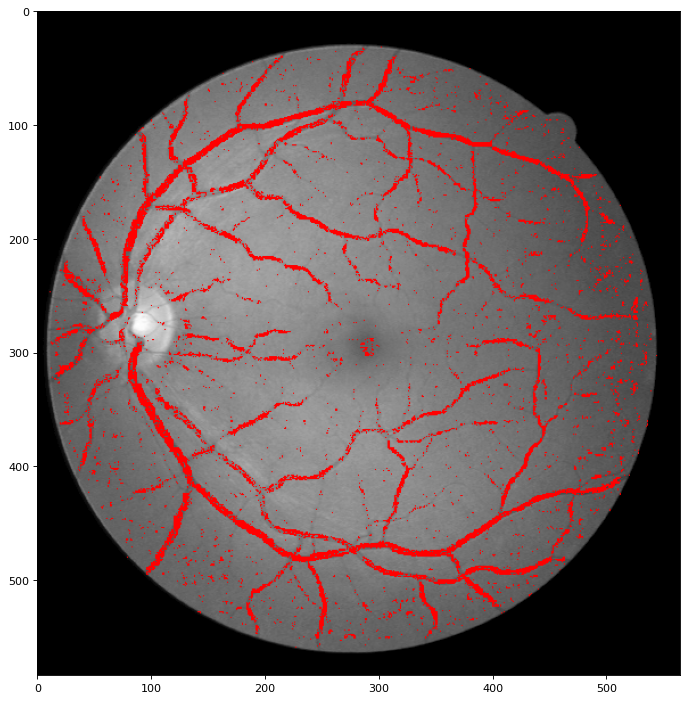

Accuracy score: 0.9066512463794492

F1 score: 0.5710132904370231

Confusion matrix:

     t/p      0     1 
        0 1150839 36706 
        1 90501 84661 
Sensivity: 0.4833297176328199
Specificity: 0.969090855504423


(0.907, 0.571, 1150839, 36706, 90501, 84661)

In [15]:
main(lgb=True, plot_once=True)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.527224 seconds.
You can set `force_col_wise=true` to remove the overhead.


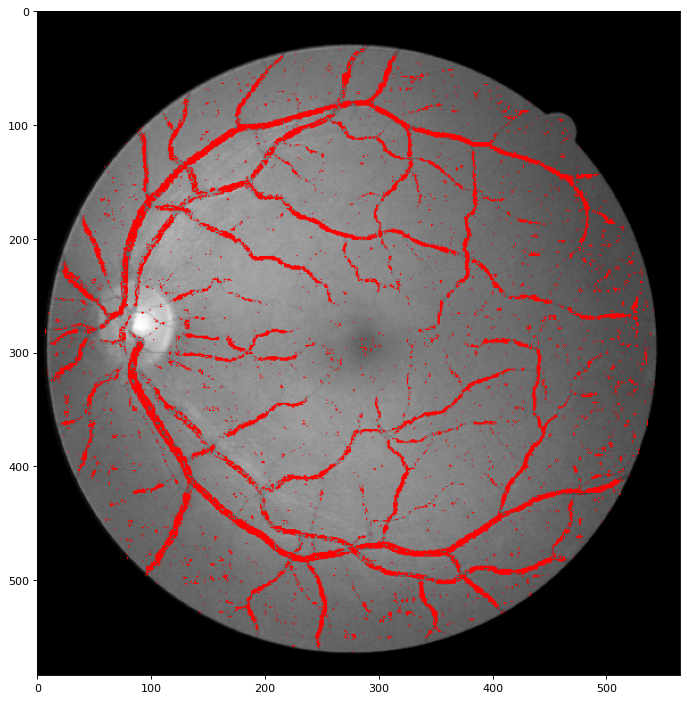

Accuracy score: 0.9132454738986444

F1 score: 0.6065896180736964

Confusion matrix:

     t/p      0     1 
        0 1153345 34200 
        1 84021 91141 
Sensivity: 0.5203240428860141
Specificity: 0.9712010913270654


(0.913, 0.607, 1153345, 34200, 84021, 91141)

In [16]:
main(lgb=True, plot_once=True, all_lbp=False, extra_features={'train': df_train_pn, 'test': df_test_pn})

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.704736 seconds.
You can set `force_col_wise=true` to remove the overhead.


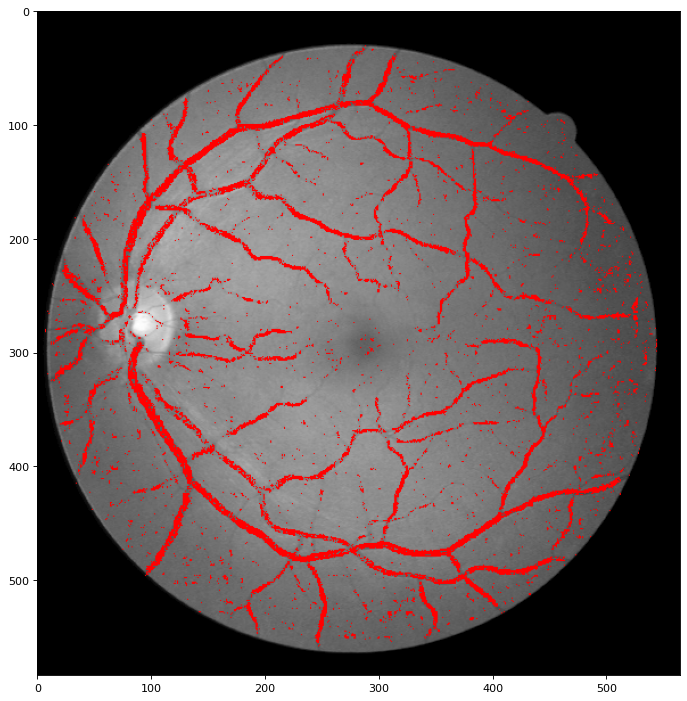

Accuracy score: 0.9134494796019981

F1 score: 0.6083332503129868

Confusion matrix:

     t/p      0     1 
        0 1153170 34375 
        1 83568 91594 
Sensivity: 0.5229102202532513
Specificity: 0.9710537284902888


(0.913, 0.608, 1153170, 34375, 83568, 91594)

In [17]:
main(lgb=True, plot_once=True, all_lbp=True, extra_features={'train': df_train_pn, 'test': df_test_pn})